<a href="https://www.kaggle.com/code/toutatsu/mnist-pytorch-cnn?scriptVersionId=91009372" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1>template notebook</h1>

import libraries

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import sys
import io

import math
import random
import pprint
import time
import datetime
import typing
import json
import glob
import requests
import warnings
import gc
from pprint import pprint
import re

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

import seaborn as sns
sns.set()

from tqdm import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/
import transformers #https://huggingface.co/transformers/

import torchvision
import torchtext

CFG

In [2]:
class CFG():
    
    data_path="/kaggle/input/digit-recognizer"
    debug=False
    seed=0

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batch_size=128
    epochs=50
    learning_rate=0.1
    kFold=5
    
    amp=True


    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print(CFG.device)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())

cuda:0
0
Tesla P100-PCIE-16GB


color

In [3]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [4]:
# %%script echo skipping

train=pd.read_csv(os.path.join(CFG.data_path,"train.csv"))
test=pd.read_csv(os.path.join(CFG.data_path,"test.csv"))
sample_submission=pd.read_csv(os.path.join(CFG.data_path,"sample_submission.csv"),index_col='ImageId')

if CFG.debug:
    #train=train[:len(train)//50]
    train=train.sample(frac=0.1)

df=pd.concat([train,test])
# train=df[:len(train)].copy()
# test=df[len(train):].copy()


data={'train':None,'val':None,'test':test}

from sklearn.model_selection import train_test_split
data['train'], data['val'] = sklearn.model_selection.train_test_split(
    train,
    test_size=0.2,
    random_state=CFG.seed, 
    stratify=train["label"],
)
data['train']=data['train'].reset_index(drop=True)
data['val']=data['val'].reset_index(drop=True)

In [5]:
data['train']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33596,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33597,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33598,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data['val']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8396,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8397,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8398,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data['test']

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dataset

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,digits,labels,phase='train',transform=None):
        self.digits=digits
        self.labels=labels
        self.phase=phase #train/val/test
        self.transform=transform
        
    def __len__(self):
        return len(self.digits)

    def __getitem__(self,idx):
        
        datum=np.array(self.digits.loc[idx],dtype=np.uint8).reshape((28,28,1))
        if self.transform:datum=self.transform(datum)
        
        return {'digit':datum,'label':self.labels.loc[idx]}

In [9]:
normalize=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

augmentation=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomApply(
        [
            torchvision.transforms.RandomRotation(degrees=(-20, 20)),
            torchvision.transforms.RandomResizedCrop((28,28), scale=(0.8, 1.0)),
        ],
        p=0.8
    ),
])


In [10]:
dataset={
    'train':Dataset(data['train'].drop('label',axis=1),data['train']['label'],'train',augmentation),
    'val'  :Dataset(data['val'].drop('label',axis=1)  ,data['val']['label']  ,'val'  ,normalize),
    'test' :Dataset(data['test']    ,pd.Series(np.full(len(data['test']),-1)),'test' ,normalize),
}

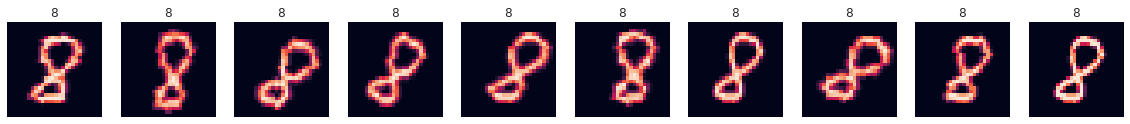

In [11]:
plt.figure(figsize=(20,10))
for i in range(10):  
    plt.subplot(1, 10, i+1)
    plt.imshow(dataset['train'][8]['digit'][0,:,:])
    plt.axis('off')
    plt.title(data['train'].iloc[8,0])
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  This is separate from the ipykernel package so we can avoid doing imports until


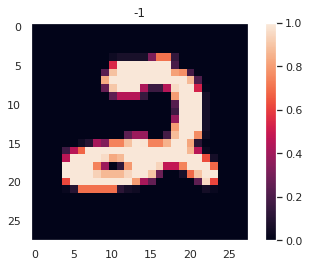

In [12]:
plt.imshow(dataset['test'][0]['digit'][0,:,:])
plt.grid(False)
plt.colorbar()
plt.title(dataset['test'][0]['label'])
plt.show()

# Dataloader

In [13]:
dataloader={
    'train':
    torch.utils.data.DataLoader(
        dataset['train'],
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=os.cpu_count(),
        pin_memory=True
    ),
    'val':
    torch.utils.data.DataLoader(
        dataset['val'],
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True
    ),
    'test':
    torch.utils.data.DataLoader(
        dataset['test'],
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True
    )
}

In [14]:
# 動作確認
# next(iter(dataloader["test"]))  # 1番目の要素を取り出す


# Model

In [15]:
#https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
# 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10
# with 40% dropout, batch normalization, and data augmentation added

In [16]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv=torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32,32,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32,32,5,2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(0.4),
            
            torch.nn.Conv2d(32,64,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64,64,3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64,64,5),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(0.4),
            
        )
        
        self.flatten = torch.nn.Flatten()
        
        self.linear=torch.nn.Sequential(
            torch.nn.Linear(256,10)
        )
        
        self.softmax=torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x=self.flatten(x)
        x=self.linear(x)
        x=self.softmax(x)
        return x

In [17]:
cnn=CNN()
cnn.to(CFG.device)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (17): ReLU()
    (18): BatchNorm2d(64, eps=1e

# Trainer

In [18]:
class Trainer():

    def __init__(self):
        self.loss_fun=torch.nn.CrossEntropyLoss()
        self.score_fun=lambda pre,ground_truth:np.argmax(pre.detach().cpu().numpy(),axis=1)==ground_truth.detach().cpu().numpy()

        self.optimizer=None
        self.lr_scheduler=None
        self.scaler=torch.cuda.amp.GradScaler(enabled=CFG.amp) 

    
    def train_val_test(self,model,dataloader,phase,epoch=-1):

        model.train() if phase=='train' else model.eval()   # モデルのモード
        #model.to(CFG.device)

        predictions=[]
        losses=[]
        scores=[]

        # データローダーからミニバッチを取り出すループ

        #tqdm_bar=io.StringIO() file=tqdm_bar,desc=f"model description\n{epoch} {phase}"
        for batch in tqdm(dataloader):
            
            # optimizerを初期化
            if phase=='train':self.optimizer.zero_grad()

            # 順伝搬（forward）計算
            with torch.set_grad_enabled(phase=='train'):
                digits = batch['digit'].to(CFG.device,non_blocking=True)
                targets = batch['label'].to(CFG.device,non_blocking=True)
                
                with torch.cuda.amp.autocast(enabled=CFG.amp):
                    
                    preds=model(digits)#,targets)
                    
                    if phase!='test':
                        loss = self.loss_fun(preds,targets)  # 損失を計算
                        losses.append(loss.item())
                        
                        score = self.score_fun(preds, targets) # 正誤判定
                        scores.extend(score)
                        
#                         print(np.argmax(preds.detach().cpu().numpy(),axis=1))
#                         print(targets.detach().cpu().numpy())
        
        
        

                # 訓練時はバックプロパゲーション
                if phase == 'train':
                    if CFG.amp:
                        #scalerの場合
                        self.scaler.scale(loss).backward() # ロスのバックワード
                        self.scaler.step(self.optimizer) # オプティマイザーの更新
                        self.scaler.update() # スケーラーの更新
                    else:
                        loss.backward()
                        self.optimizer.step()

            predictions.extend(np.argmax(preds.detach().cpu().numpy(),axis=1))

            del preds
            if phase!='test':del loss,score
            torch.cuda.empty_cache()
            gc.collect()

        return predictions,losses,scores
    
    
    def learning(self,model,dataloader):
        
        start_time=datetime.datetime.utcnow() + datetime.timedelta(hours=9)

        self.optimizer=transformers.AdamW(model.parameters(), CFG.learning_rate,betas=(0.9, 0.999), weight_decay=1e-2)
        self.lr_scheduler=torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda epoch:CFG.learning_rate*(0.5**(epoch//5)),verbose=True)
        

        losses={'train':[],'val':[]}
        scores={'train':[],'val':[]}

        #self.initialize(CFG.seed,fold)
        #dataset,dataloader,model,optimizer,scheduler,scaler=initialize(CFG.seed,fold)

        bestscore=0

        for epoch in range(CFG.epochs):
            print(f"epoch:{epoch}")

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            # if (epoch == 0) and (phase == 'train'):train_continue

            _,loss,score=self.train_val_test(model,dataloader['train'],'train',epoch=epoch)
            print(color("train score",bg='CYAN')+' :',color(np.mean(score),'CYAN'))
            scores['train'].append(np.mean(score))
            losses['train'].append(np.mean(loss))

            _,loss,score=self.train_val_test(model,dataloader['val'],'val',epoch=epoch)
            print(color("val score",bg='RED')+' :',color(np.mean(score),'RED'))
            scores['val'].append(np.mean(score))
            losses['val'].append(np.mean(loss))

            if bestscore < scores['val'][-1]:
                bestscore = scores['val'][-1]
                print(color("BEST SCORE",bg='YELLOW')+' :',color(bestscore,'YELLOW'))

                bestmodel={
                    'state_dict': model.state_dict(),
                    'optimizer_dict': self.optimizer.state_dict(),
                    'bestscore':bestscore,
                    'seed':CFG.seed
                }

            #print(preds)

            self.lr_scheduler.step() # 学習率の更新 

        exe_time=datetime.datetime.utcnow() + datetime.timedelta(hours=9)-start_time
        print(exe_time)

        #torch.save(bestmodel,"bestmodel:"+str(bestscore)+".pth")
        
        
        return scores,losses,bestmodel
            


trainer=Trainer()

submission

In [19]:
# trainer.optimizer=transformers.AdamW(cnn.parameters(), CFG.learning_rate,betas=(0.9, 0.999), weight_decay=1e-2)
# trainer.lr_scheduler=torch.optim.lr_scheduler.LambdaLR(trainer.optimizer, lr_lambda=lambda epoch:CFG.learning_rate*(0.5**(epoch//5)),verbose=True)
        
# predictions,losses,scores=trainer.train_val_test(cnn,dataloader['train'],'train',epoch=0)
# np.mean(scores)

In [20]:
scores,losses,bestmodel=trainer.learning(cnn,dataloader)

Adjusting learning rate of group 0 to 1.0000e-02.
epoch:0


100%|██████████| 263/263 [01:07<00:00,  3.90it/s]


train score : 0.8876190476190476


100%|██████████| 66/66 [00:12<00:00,  5.11it/s]


val score : 0.9560714285714286
BEST SCORE : 0.9560714285714286
Adjusting learning rate of group 0 to 1.0000e-02.
epoch:1


100%|██████████| 263/263 [01:00<00:00,  4.32it/s]


train score : 0.9414880952380953


100%|██████████| 66/66 [00:12<00:00,  5.11it/s]


val score : 0.9714285714285714
BEST SCORE : 0.9714285714285714
Adjusting learning rate of group 0 to 1.0000e-02.
epoch:2


100%|██████████| 263/263 [01:01<00:00,  4.25it/s]


train score : 0.9499404761904762


100%|██████████| 66/66 [00:12<00:00,  5.21it/s]


val score : 0.978452380952381
BEST SCORE : 0.978452380952381
Adjusting learning rate of group 0 to 1.0000e-02.
epoch:3


100%|██████████| 263/263 [01:01<00:00,  4.29it/s]


train score : 0.9519642857142857


100%|██████████| 66/66 [00:13<00:00,  4.97it/s]


val score : 0.9764285714285714
Adjusting learning rate of group 0 to 1.0000e-02.
epoch:4


100%|██████████| 263/263 [01:01<00:00,  4.27it/s]


train score : 0.9588095238095238


100%|██████████| 66/66 [00:13<00:00,  5.06it/s]


val score : 0.9760714285714286
Adjusting learning rate of group 0 to 5.0000e-03.
epoch:5


100%|██████████| 263/263 [01:02<00:00,  4.21it/s]


train score : 0.9681547619047619


100%|██████████| 66/66 [00:12<00:00,  5.29it/s]


val score : 0.986547619047619
BEST SCORE : 0.986547619047619
Adjusting learning rate of group 0 to 5.0000e-03.
epoch:6


100%|██████████| 263/263 [01:02<00:00,  4.22it/s]


train score : 0.9714880952380952


100%|██████████| 66/66 [00:12<00:00,  5.20it/s]


val score : 0.9858333333333333
Adjusting learning rate of group 0 to 5.0000e-03.
epoch:7


100%|██████████| 263/263 [01:01<00:00,  4.27it/s]


train score : 0.9716666666666667


100%|██████████| 66/66 [00:12<00:00,  5.23it/s]


val score : 0.9863095238095239
Adjusting learning rate of group 0 to 5.0000e-03.
epoch:8


100%|██████████| 263/263 [01:01<00:00,  4.26it/s]


train score : 0.9733333333333334


100%|██████████| 66/66 [00:12<00:00,  5.40it/s]


val score : 0.9861904761904762
Adjusting learning rate of group 0 to 5.0000e-03.
epoch:9


100%|██████████| 263/263 [01:02<00:00,  4.23it/s]


train score : 0.9721726190476191


100%|██████████| 66/66 [00:12<00:00,  5.17it/s]


val score : 0.9871428571428571
BEST SCORE : 0.9871428571428571
Adjusting learning rate of group 0 to 2.5000e-03.
epoch:10


100%|██████████| 263/263 [00:58<00:00,  4.47it/s]


train score : 0.9776488095238095


100%|██████████| 66/66 [00:12<00:00,  5.34it/s]


val score : 0.9913095238095239
BEST SCORE : 0.9913095238095239
Adjusting learning rate of group 0 to 2.5000e-03.
epoch:11


100%|██████████| 263/263 [00:59<00:00,  4.39it/s]


train score : 0.9807440476190477


100%|██████████| 66/66 [00:12<00:00,  5.47it/s]


val score : 0.9911904761904762
Adjusting learning rate of group 0 to 2.5000e-03.
epoch:12


100%|██████████| 263/263 [01:02<00:00,  4.19it/s]


train score : 0.9808928571428571


100%|██████████| 66/66 [00:12<00:00,  5.38it/s]


val score : 0.9907142857142858
Adjusting learning rate of group 0 to 2.5000e-03.
epoch:13


100%|██████████| 263/263 [01:02<00:00,  4.22it/s]


train score : 0.9816964285714286


100%|██████████| 66/66 [00:13<00:00,  4.98it/s]


val score : 0.9921428571428571
BEST SCORE : 0.9921428571428571
Adjusting learning rate of group 0 to 2.5000e-03.
epoch:14


100%|██████████| 263/263 [01:03<00:00,  4.17it/s]


train score : 0.9824107142857142


100%|██████████| 66/66 [00:12<00:00,  5.09it/s]


val score : 0.9917857142857143
Adjusting learning rate of group 0 to 1.2500e-03.
epoch:15


100%|██████████| 263/263 [01:04<00:00,  4.10it/s]


train score : 0.9843154761904762


100%|██████████| 66/66 [00:12<00:00,  5.39it/s]


val score : 0.9923809523809524
BEST SCORE : 0.9923809523809524
Adjusting learning rate of group 0 to 1.2500e-03.
epoch:16


100%|██████████| 263/263 [01:03<00:00,  4.13it/s]


train score : 0.9855654761904762


100%|██████████| 66/66 [00:12<00:00,  5.33it/s]


val score : 0.9928571428571429
BEST SCORE : 0.9928571428571429
Adjusting learning rate of group 0 to 1.2500e-03.
epoch:17


100%|██████████| 263/263 [01:03<00:00,  4.15it/s]


train score : 0.9852083333333334


100%|██████████| 66/66 [00:13<00:00,  4.79it/s]


val score : 0.9930952380952381
BEST SCORE : 0.9930952380952381
Adjusting learning rate of group 0 to 1.2500e-03.
epoch:18


100%|██████████| 263/263 [01:02<00:00,  4.21it/s]


train score : 0.9853571428571428


100%|██████████| 66/66 [00:13<00:00,  4.76it/s]


val score : 0.993452380952381
BEST SCORE : 0.993452380952381
Adjusting learning rate of group 0 to 1.2500e-03.
epoch:19


100%|██████████| 263/263 [01:03<00:00,  4.12it/s]


train score : 0.9859523809523809


100%|██████████| 66/66 [00:12<00:00,  5.25it/s]


val score : 0.9936904761904762
BEST SCORE : 0.9936904761904762
Adjusting learning rate of group 0 to 6.2500e-04.
epoch:20


100%|██████████| 263/263 [01:03<00:00,  4.15it/s]


train score : 0.9872619047619048


100%|██████████| 66/66 [00:13<00:00,  5.06it/s]


val score : 0.9933333333333333
Adjusting learning rate of group 0 to 6.2500e-04.
epoch:21


100%|██████████| 263/263 [01:03<00:00,  4.12it/s]


train score : 0.9875297619047619


100%|██████████| 66/66 [00:12<00:00,  5.10it/s]


val score : 0.9938095238095238
BEST SCORE : 0.9938095238095238
Adjusting learning rate of group 0 to 6.2500e-04.
epoch:22


100%|██████████| 263/263 [01:03<00:00,  4.12it/s]


train score : 0.9870833333333333


100%|██████████| 66/66 [00:14<00:00,  4.63it/s]


val score : 0.9938095238095238
Adjusting learning rate of group 0 to 6.2500e-04.
epoch:23


100%|██████████| 263/263 [01:02<00:00,  4.19it/s]


train score : 0.9883333333333333


100%|██████████| 66/66 [00:13<00:00,  4.90it/s]


val score : 0.9932142857142857
Adjusting learning rate of group 0 to 6.2500e-04.
epoch:24


100%|██████████| 263/263 [01:03<00:00,  4.11it/s]


train score : 0.9877083333333333


100%|██████████| 66/66 [00:12<00:00,  5.29it/s]


val score : 0.9938095238095238
Adjusting learning rate of group 0 to 3.1250e-04.
epoch:25


100%|██████████| 263/263 [01:04<00:00,  4.09it/s]


train score : 0.9892559523809524


100%|██████████| 66/66 [00:12<00:00,  5.08it/s]


val score : 0.9938095238095238
Adjusting learning rate of group 0 to 3.1250e-04.
epoch:26


100%|██████████| 263/263 [01:04<00:00,  4.10it/s]


train score : 0.9887202380952381


100%|██████████| 66/66 [00:12<00:00,  5.30it/s]


val score : 0.9941666666666666
BEST SCORE : 0.9941666666666666
Adjusting learning rate of group 0 to 3.1250e-04.
epoch:27


100%|██████████| 263/263 [01:04<00:00,  4.08it/s]


train score : 0.9889880952380953


100%|██████████| 66/66 [00:12<00:00,  5.27it/s]


val score : 0.9936904761904762
Adjusting learning rate of group 0 to 3.1250e-04.
epoch:28


100%|██████████| 263/263 [01:05<00:00,  4.02it/s]


train score : 0.9901190476190476


100%|██████████| 66/66 [00:13<00:00,  4.79it/s]


val score : 0.9944047619047619
BEST SCORE : 0.9944047619047619
Adjusting learning rate of group 0 to 3.1250e-04.
epoch:29


100%|██████████| 263/263 [01:03<00:00,  4.13it/s]


train score : 0.9889285714285714


100%|██████████| 66/66 [00:13<00:00,  4.75it/s]


val score : 0.9944047619047619
Adjusting learning rate of group 0 to 1.5625e-04.
epoch:30


100%|██████████| 263/263 [01:03<00:00,  4.17it/s]


train score : 0.9896428571428572


100%|██████████| 66/66 [00:13<00:00,  4.77it/s]


val score : 0.9946428571428572
BEST SCORE : 0.9946428571428572
Adjusting learning rate of group 0 to 1.5625e-04.
epoch:31


100%|██████████| 263/263 [01:04<00:00,  4.06it/s]


train score : 0.9899107142857143


100%|██████████| 66/66 [00:13<00:00,  5.05it/s]


val score : 0.9946428571428572
Adjusting learning rate of group 0 to 1.5625e-04.
epoch:32


100%|██████████| 263/263 [01:03<00:00,  4.13it/s]


train score : 0.9897916666666666


100%|██████████| 66/66 [00:12<00:00,  5.39it/s]


val score : 0.9941666666666666
Adjusting learning rate of group 0 to 1.5625e-04.
epoch:33


100%|██████████| 263/263 [01:03<00:00,  4.15it/s]


train score : 0.9899404761904762


100%|██████████| 66/66 [00:12<00:00,  5.35it/s]


val score : 0.9944047619047619
Adjusting learning rate of group 0 to 1.5625e-04.
epoch:34


100%|██████████| 263/263 [01:03<00:00,  4.14it/s]


train score : 0.9889285714285714


100%|██████████| 66/66 [00:14<00:00,  4.57it/s]


val score : 0.9938095238095238
Adjusting learning rate of group 0 to 7.8125e-05.
epoch:35


100%|██████████| 263/263 [01:01<00:00,  4.30it/s]


train score : 0.9905059523809524


100%|██████████| 66/66 [00:14<00:00,  4.62it/s]


val score : 0.9941666666666666
Adjusting learning rate of group 0 to 7.8125e-05.
epoch:36


100%|██████████| 263/263 [01:03<00:00,  4.14it/s]


train score : 0.990297619047619


100%|██████████| 66/66 [00:12<00:00,  5.29it/s]


val score : 0.9941666666666666
Adjusting learning rate of group 0 to 7.8125e-05.
epoch:37


100%|██████████| 263/263 [01:03<00:00,  4.15it/s]


train score : 0.9896428571428572


100%|██████████| 66/66 [00:12<00:00,  5.22it/s]


val score : 0.9946428571428572
Adjusting learning rate of group 0 to 7.8125e-05.
epoch:38


100%|██████████| 263/263 [01:03<00:00,  4.12it/s]


train score : 0.9899404761904762


100%|██████████| 66/66 [00:12<00:00,  5.36it/s]


val score : 0.9946428571428572
Adjusting learning rate of group 0 to 7.8125e-05.
epoch:39


100%|██████████| 263/263 [01:03<00:00,  4.14it/s]


train score : 0.9899702380952381


100%|██████████| 66/66 [00:12<00:00,  5.28it/s]


val score : 0.9941666666666666
Adjusting learning rate of group 0 to 3.9063e-05.
epoch:40


100%|██████████| 263/263 [01:03<00:00,  4.11it/s]


train score : 0.9906845238095238


100%|██████████| 66/66 [00:12<00:00,  5.14it/s]


val score : 0.9940476190476191
Adjusting learning rate of group 0 to 3.9063e-05.
epoch:41


100%|██████████| 263/263 [01:03<00:00,  4.12it/s]


train score : 0.989672619047619


100%|██████████| 66/66 [00:12<00:00,  5.36it/s]


val score : 0.9942857142857143
Adjusting learning rate of group 0 to 3.9063e-05.
epoch:42


100%|██████████| 263/263 [01:04<00:00,  4.09it/s]


train score : 0.9902380952380953


100%|██████████| 66/66 [00:12<00:00,  5.32it/s]


val score : 0.9942857142857143
Adjusting learning rate of group 0 to 3.9063e-05.
epoch:43


100%|██████████| 263/263 [01:04<00:00,  4.09it/s]


train score : 0.9904761904761905


100%|██████████| 66/66 [00:14<00:00,  4.64it/s]


val score : 0.9944047619047619
Adjusting learning rate of group 0 to 3.9063e-05.
epoch:44


100%|██████████| 263/263 [01:01<00:00,  4.25it/s]


train score : 0.9897321428571428


100%|██████████| 66/66 [00:15<00:00,  4.36it/s]


val score : 0.9940476190476191
Adjusting learning rate of group 0 to 1.9531e-05.
epoch:45


100%|██████████| 263/263 [01:03<00:00,  4.15it/s]


train score : 0.9894047619047619


100%|██████████| 66/66 [00:12<00:00,  5.16it/s]


val score : 0.9945238095238095
Adjusting learning rate of group 0 to 1.9531e-05.
epoch:46


100%|██████████| 263/263 [01:04<00:00,  4.06it/s]


train score : 0.9900892857142857


100%|██████████| 66/66 [00:12<00:00,  5.14it/s]


val score : 0.9945238095238095
Adjusting learning rate of group 0 to 1.9531e-05.
epoch:47


100%|██████████| 263/263 [01:04<00:00,  4.06it/s]


train score : 0.9900595238095238


100%|██████████| 66/66 [00:12<00:00,  5.26it/s]


val score : 0.9946428571428572
Adjusting learning rate of group 0 to 1.9531e-05.
epoch:48


100%|██████████| 263/263 [01:05<00:00,  4.02it/s]


train score : 0.9900892857142857


100%|██████████| 66/66 [00:12<00:00,  5.28it/s]


val score : 0.9944047619047619
Adjusting learning rate of group 0 to 1.9531e-05.
epoch:49


100%|██████████| 263/263 [01:04<00:00,  4.07it/s]


train score : 0.9904464285714286


100%|██████████| 66/66 [00:12<00:00,  5.21it/s]

val score : 0.9944047619047619
Adjusting learning rate of group 0 to 9.7656e-06.
1:03:34.768267


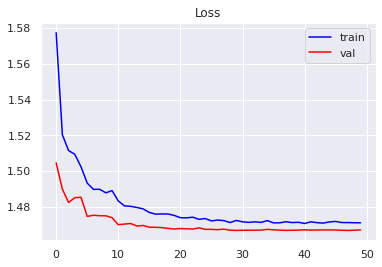

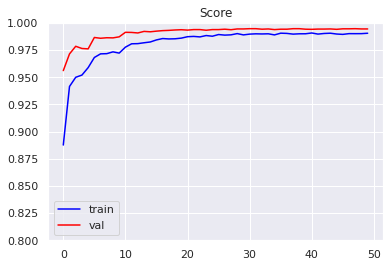

In [21]:
plt.plot(range(CFG.epochs),losses['train'],color = "blue",label='train')
plt.plot(range(CFG.epochs),losses['val'],color = "red",label='val')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(range(CFG.epochs),scores['train'],color = "blue",label='train')
plt.plot(range(CFG.epochs),scores['val'],color = "red",label='val')
plt.ylim(0.8,1)
plt.legend()
plt.title('Score')
plt.show()

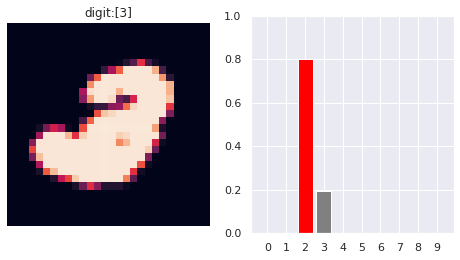

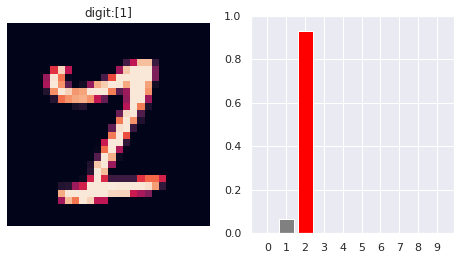

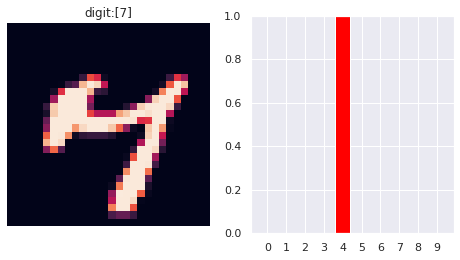

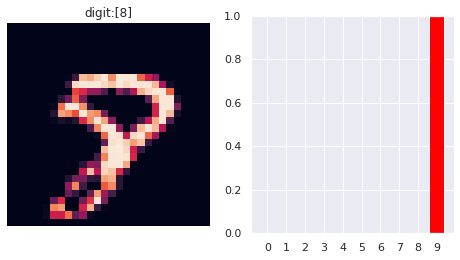

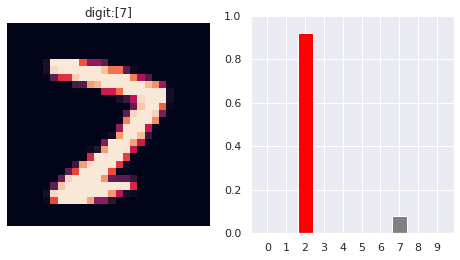

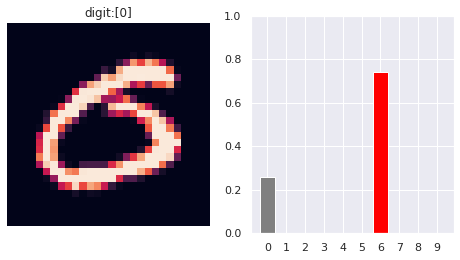

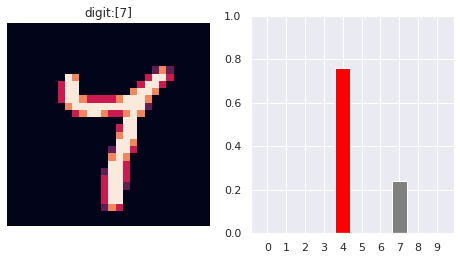

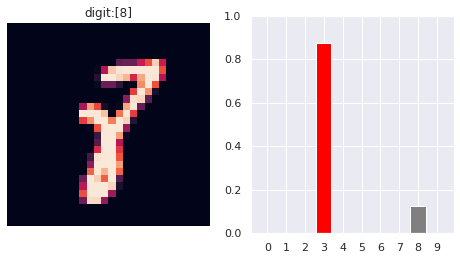

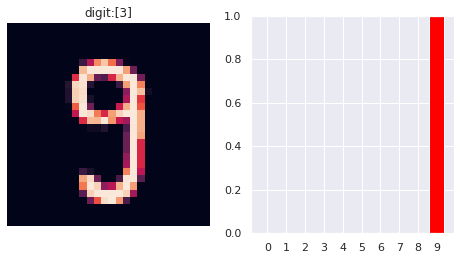

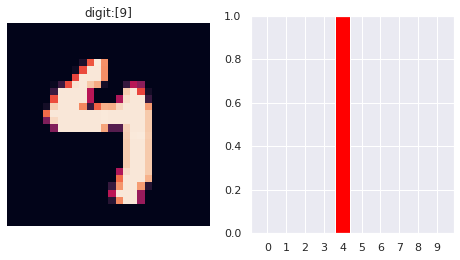

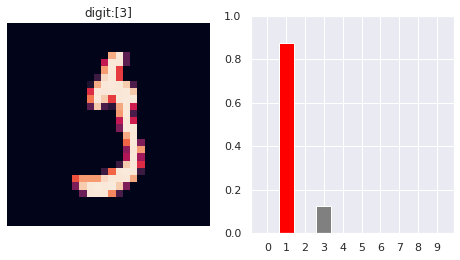

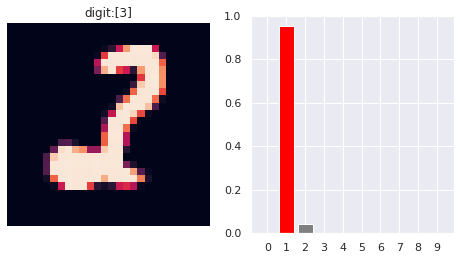

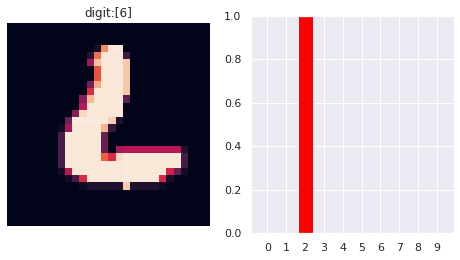

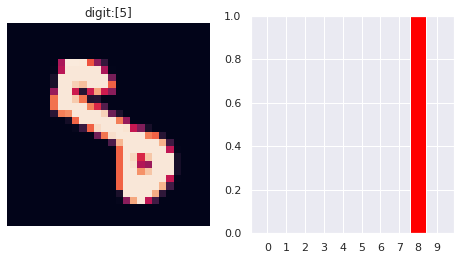

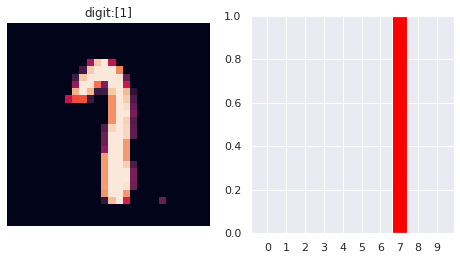

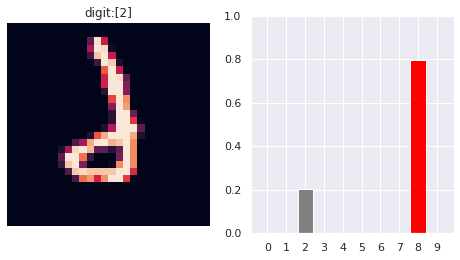

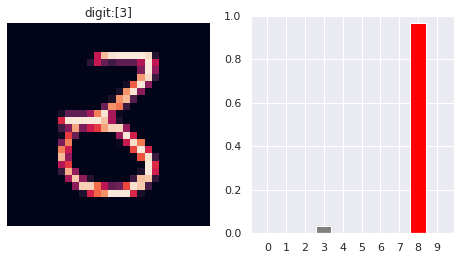

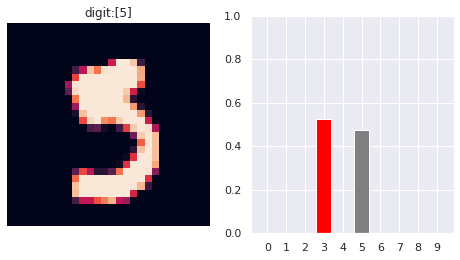

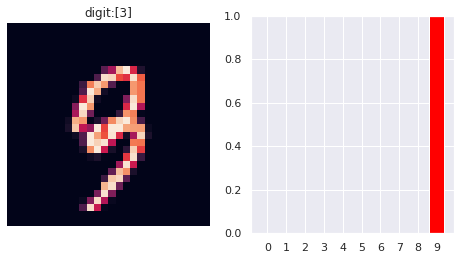

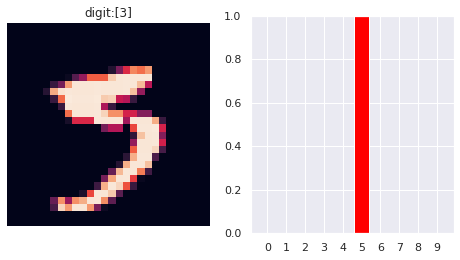

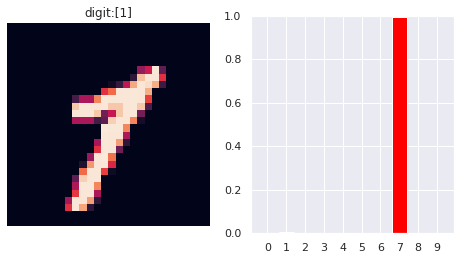

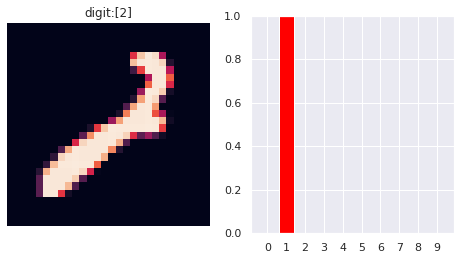

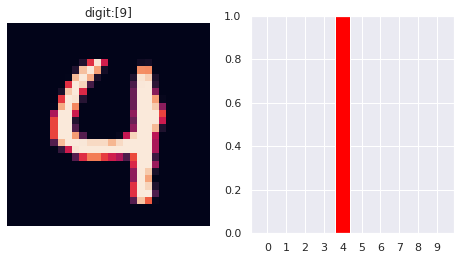

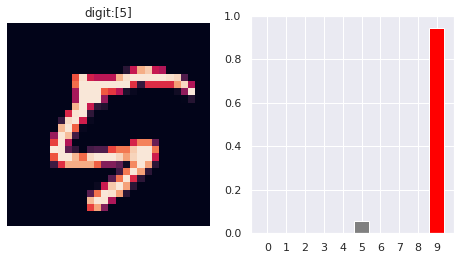

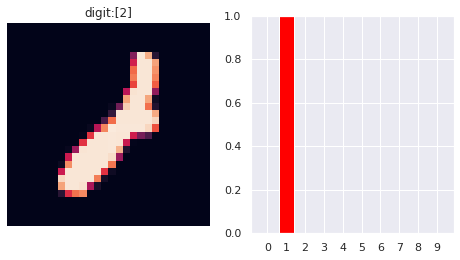

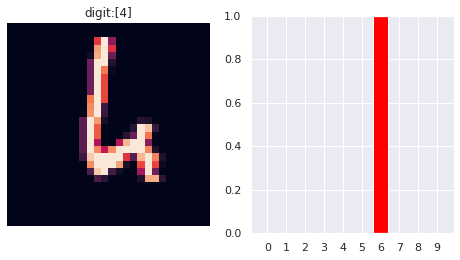

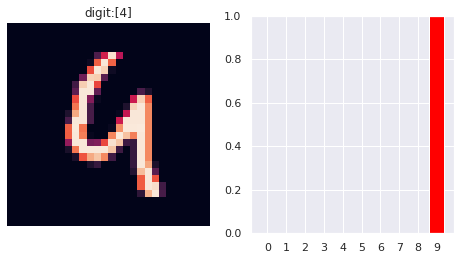

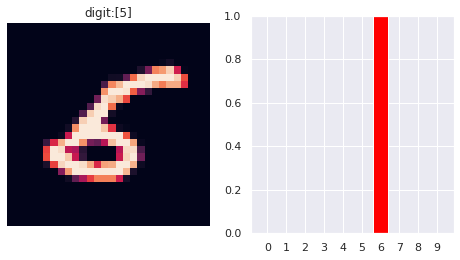

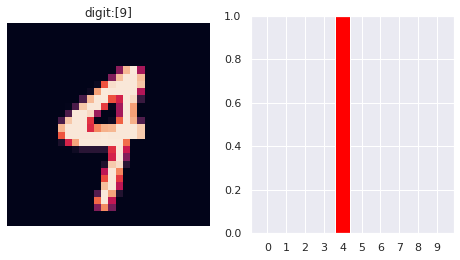

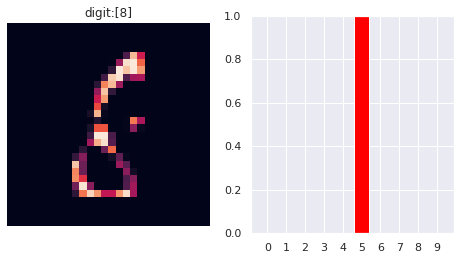

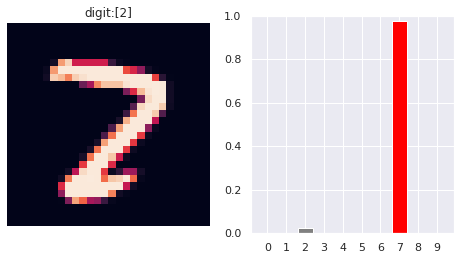

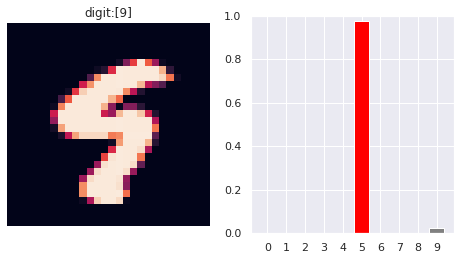

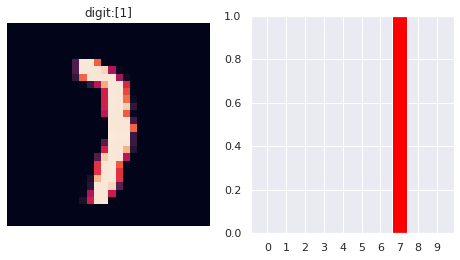

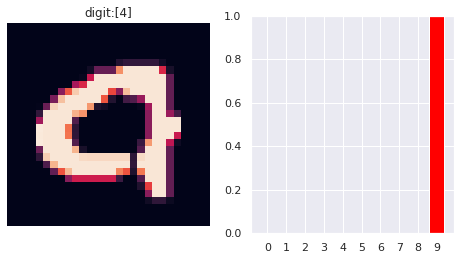

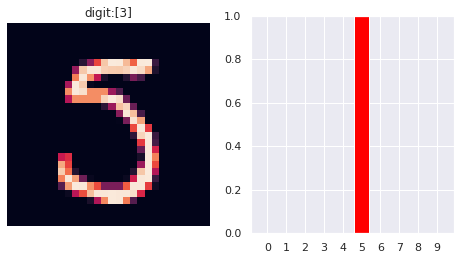

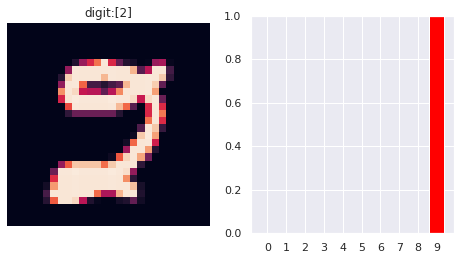

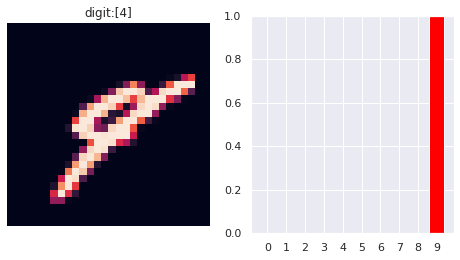

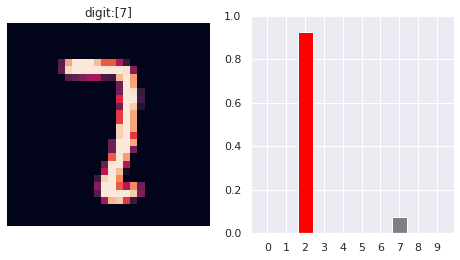

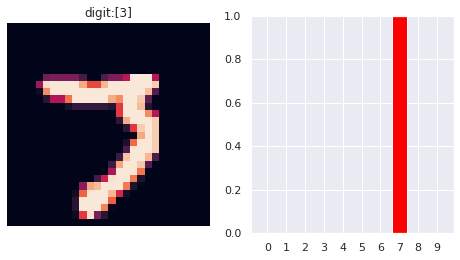

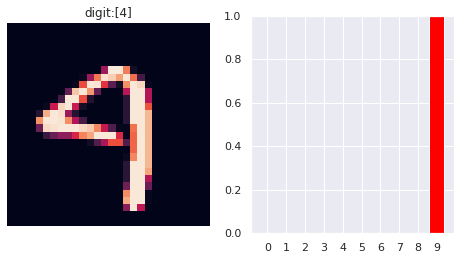

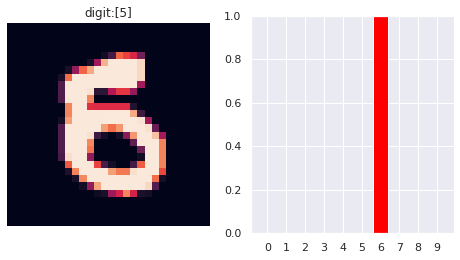

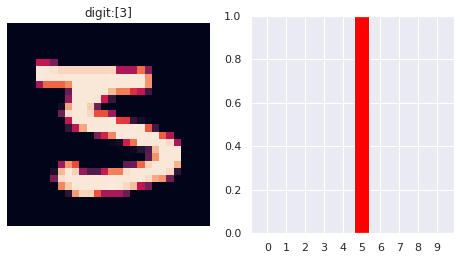

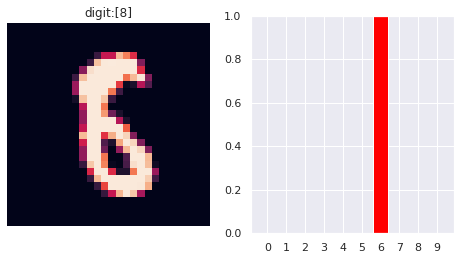

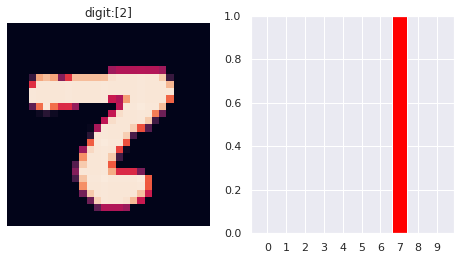

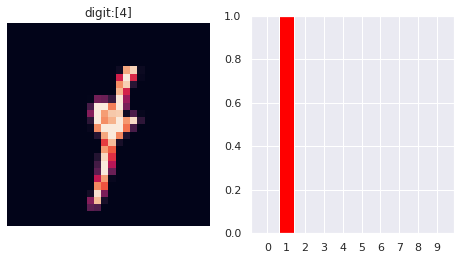

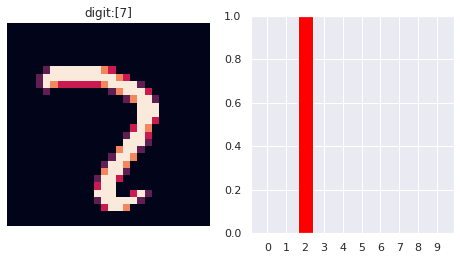

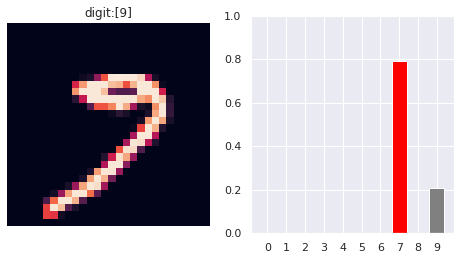

In [22]:
for batch in dataloader['val']:
    digit=batch['digit'].to(CFG.device)
    target=batch['label'].to(CFG.device)
    
    pre=cnn(digit)
    
    for i in range(CFG.batch_size):#誤判定の例のみ出力
        
        if len(target)!=CFG.batch_size:continue #最後
        if target[i] == np.argmax(pre[i].cpu().detach().numpy()):continue
        
        plt.figure(figsize=(8,4))
 
        plt.subplot(1, 2, 1)
        plt.imshow(batch['digit'][i,0,:,:])
        plt.axis('off')
        plt.title(f"digit:[{target[i]}]")

        plt.subplot(1, 2, 2)
        plt.bar(np.arange(10),
                pre[i].cpu().detach().numpy(),
                color=['red' if (x == np.argmax(pre[i].cpu().detach().numpy())) else 'grey' for x in range(10)]
        )
        plt.xticks(np.arange(10))
        plt.ylim(0,1)
        plt.show()


# hook

In [23]:
class Hook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
        
    def __del__(self):
        self.hook.remove()

In [24]:
hooks=[Hook(layer) for layer in cnn.conv]

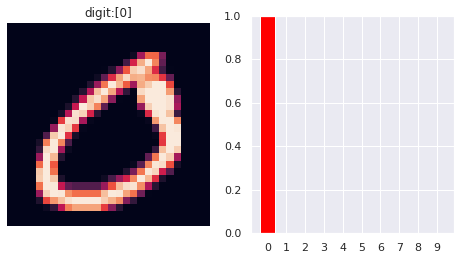

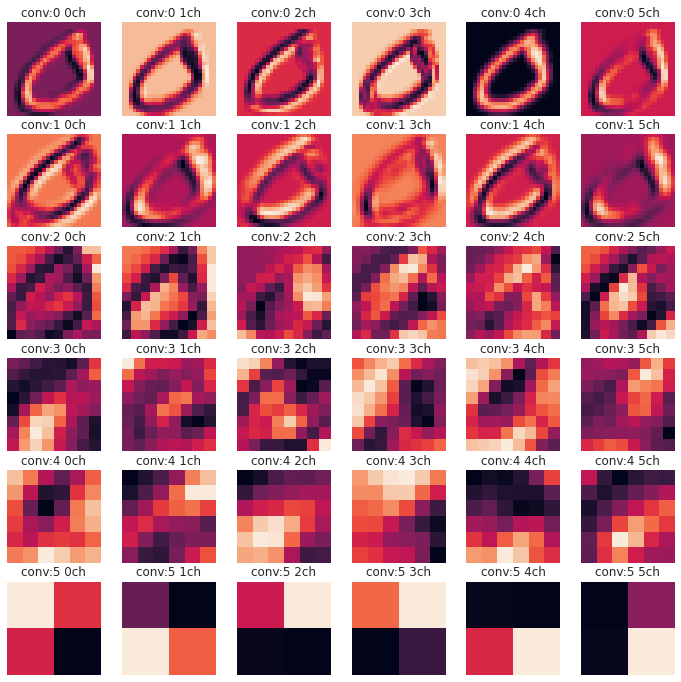

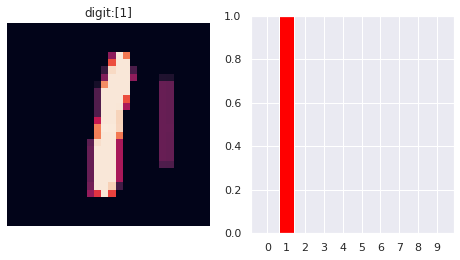

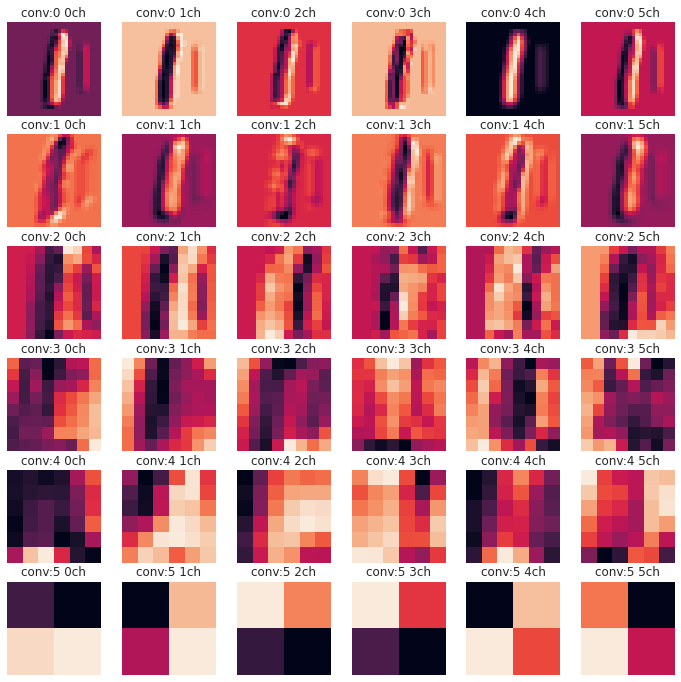

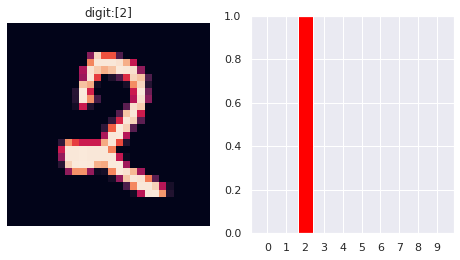

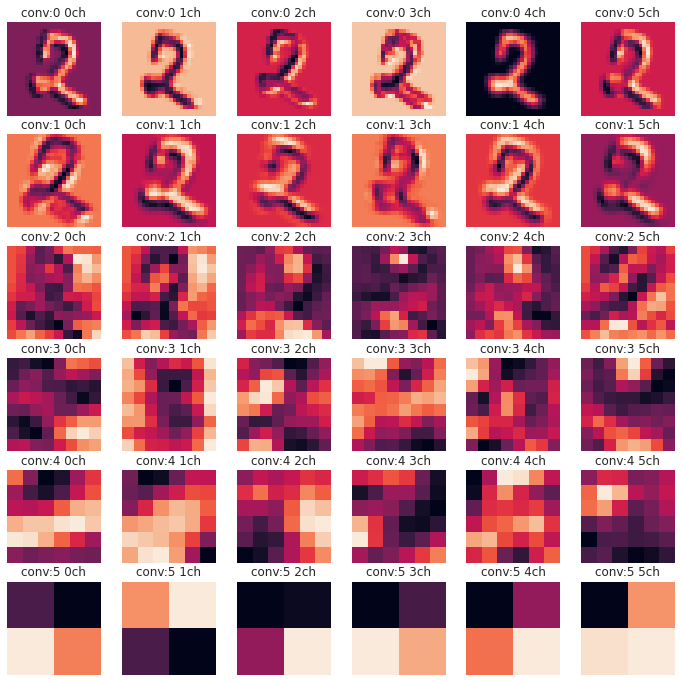

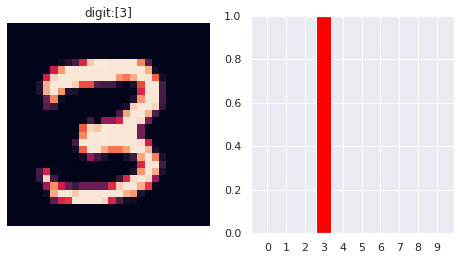

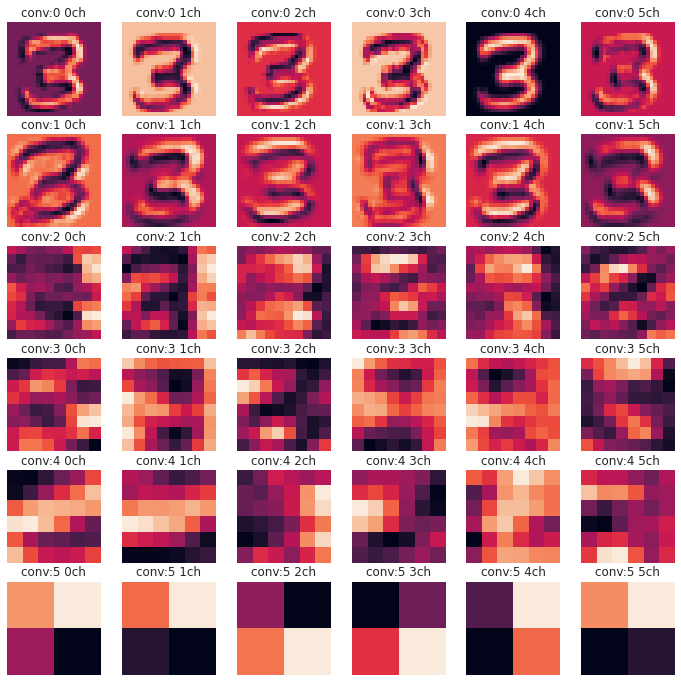

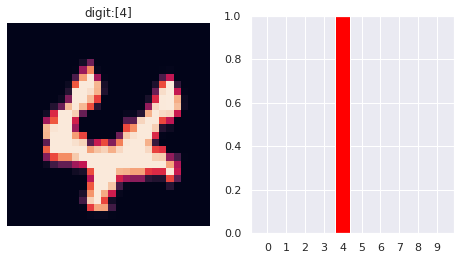

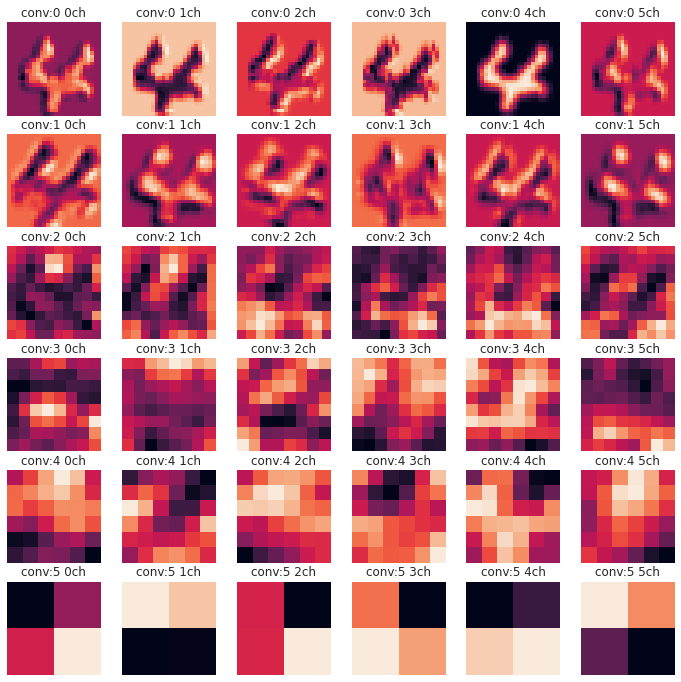

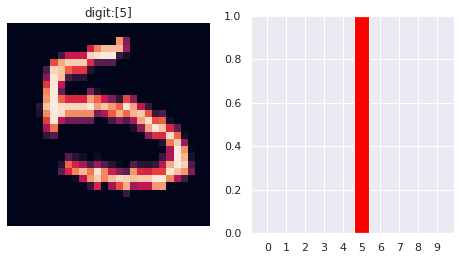

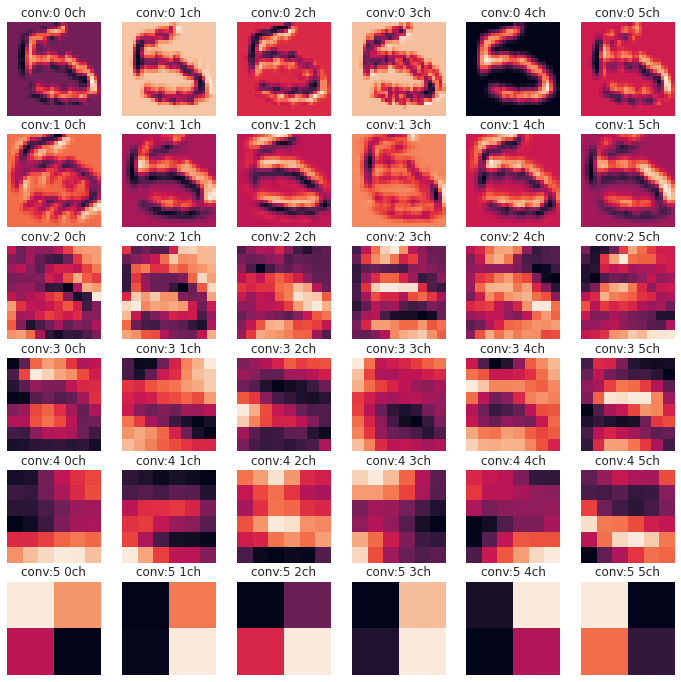

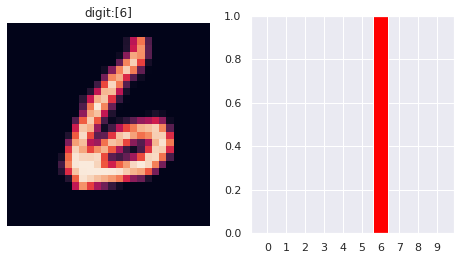

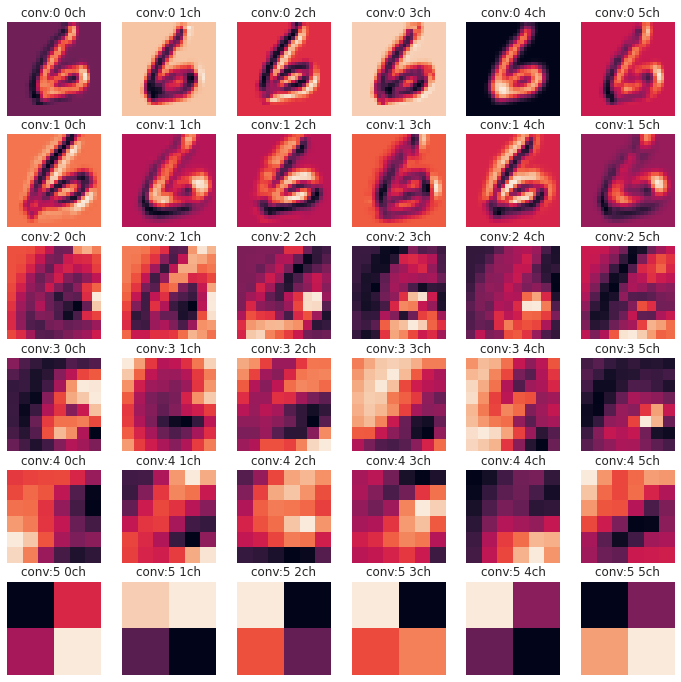

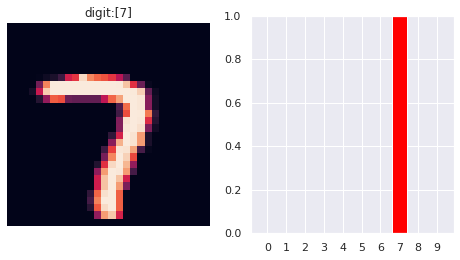

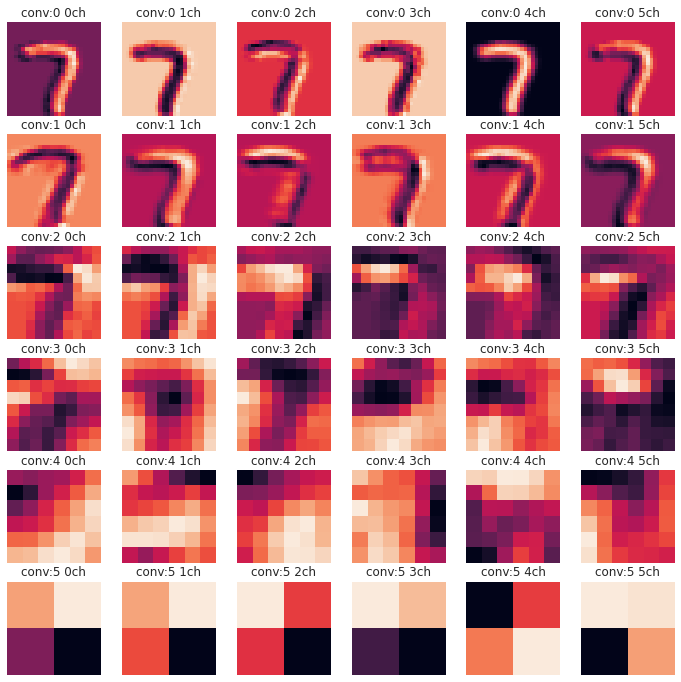

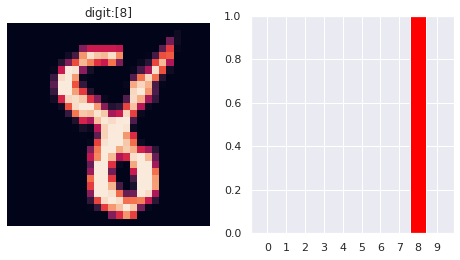

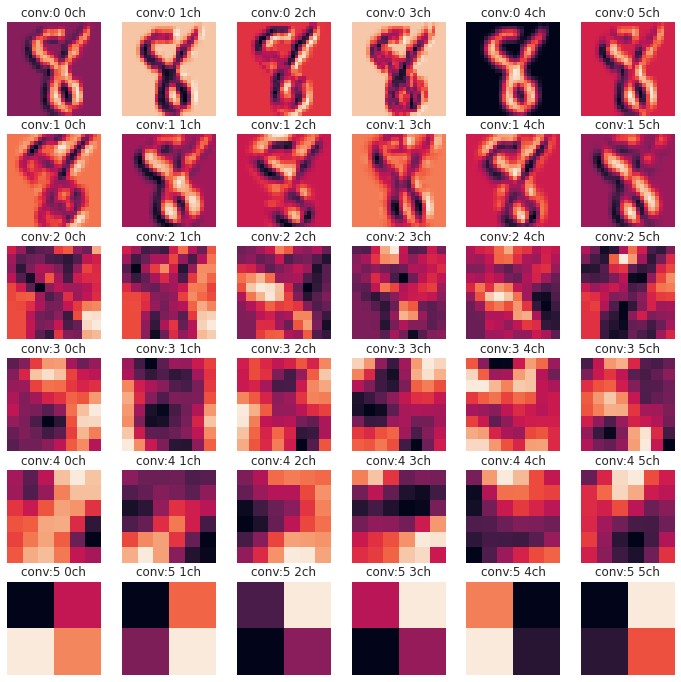

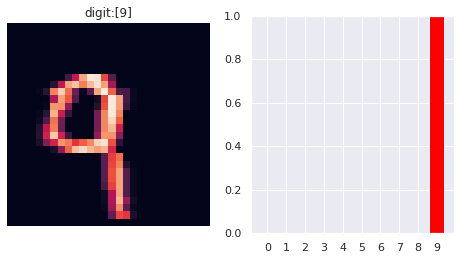

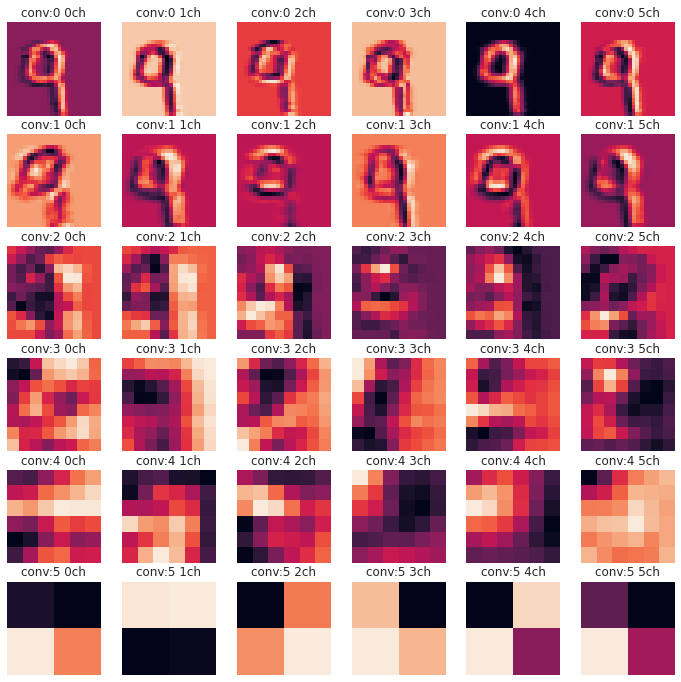

In [25]:
cnt=0
for batch in dataloader['train']:
    digit=batch['digit'].to(CFG.device)
    target=batch['label'].to(CFG.device)
    
    pre=cnn(digit)
    
    for n in range(CFG.batch_size):
        
        if cnt!=target[n]:continue

        # digit and prediction result

        plt.figure(figsize=(8,4))

        plt.subplot(1, 2, 1)
        plt.imshow(batch['digit'][n,0,:,:])
        plt.axis('off')
        plt.title(f"digit:[{target[n]}]")

        plt.subplot(1, 2, 2)
        plt.bar(np.arange(10),
            pre[n].cpu().detach().numpy(),
            color=['red' if (x == np.argmax(pre[n].cpu().detach().numpy())) else 'grey' for x in range(10)]
        )
        plt.xticks(np.arange(10))
        plt.ylim(0,1)
        plt.show()

        ######

        #Conv

        plt.figure(figsize=(12,12))

        for idx,i in enumerate([0,3,6,10,13,16]):

            for j in range(6):
                plt.subplot(6, 6, idx*6+j+1)

                plt.imshow(hooks[i].output[n,j,:,:].detach().cpu().numpy())
                plt.axis('off')
                plt.title(f"conv:{idx} {j}ch")

        plt.show()

        if cnt==9:break
        cnt+=1
        
    if cnt==9:break


# Prediction

In [26]:
cnn.load_state_dict(bestmodel['state_dict'])

<All keys matched successfully>

In [27]:
predictions,_,_=trainer.train_val_test(cnn,dataloader['test'],'test',epoch=0)

100%|██████████| 219/219 [00:41<00:00,  5.29it/s]


In [28]:
submission=pd.DataFrame(index=sample_submission.index,columns=['Label'])
submission

,Label
ImageId,
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
27996,NaN
27997,NaN
27998,NaN


In [29]:
submission.Label=predictions
submission

,Label
ImageId,
1,2
2,0
3,9
4,0
5,3
...,...
27996,9
27997,7
27998,3


In [30]:
submission.to_csv("submission.csv",index=submission.index.name)